# Finding Differentiating Images

The notebook includes a section on finding sets of images that maximally differentiate between models. For pedagogical purposes, we used a small set of 20 images from CIFAR100, but for your submission:

Use any metric and any subset of models (you can use the subset of models found in blue team submissions) to find 1,000 images that maximally differentiate models. 

You can approach this by:
1. Sampling from existing datasets
2. Using optimization techniques to generate or modify images that decrease alignment

This approach can provide valuable insights into how different models process visual information differently.

The code provides a starting point with functions for comparing random image groups, ranking by dissimilarity, and visualizing results.

In [3]:
import os
import random
import json
import numpy as np
from PIL import Image
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.manifold import MDS
from scipy.spatial import procrustes
import numpy as np
from matplotlib.gridspec import GridSpec

from thingsvision.core.cka import get_cka
from thingsvision.core.rsa import compute_rdm, correlate_rdms
from itertools import combinations, product
from sklearn.decomposition import PCA

## Find images that maximally differentiate between models

### Helper functions

In [4]:
def compare_random_image_groups(activation_dir, dataset_name, models, num_groups=5, images_per_group=20, methods=None):
    """
    Compare random groups of images using different alignment metrics.
    """
    # Load file names
    fnames = np.loadtxt(f'{activation_dir}/{dataset_name}/file_names.txt', dtype=str)
    
    # Default methods if not specified
    if methods is None:
        methods = ['cka', 'rsa', 'procrustes']
        
    # Create random groups
    random.seed(42)
    num_images = len(fnames)
    groups = {}
    for i in range(num_groups):
        groups[i] = np.array(random.sample(range(num_images), images_per_group))
    
    # Initialize results dictionary
    results = {method: np.zeros(num_groups) for method in methods}
    
    # For each model pair, compute alignment metrics for each group
    for method in methods:
        metric_values = []
        
        for idx, (model1, model2) in enumerate(combinations(models, 2)):
            print(f"Processing model pair for {method}: {model1['model_name']} vs {model2['model_name']}")
            
            for layer1, layer2 in product(model1['layers_to_extract'], model2['layers_to_extract']):
                features1 = np.load(f'{activation_dir}/{dataset_name}/{model1["model_name"]}/{layer1}/features.npy')
                features2 = np.load(f'{activation_dir}/{dataset_name}/{model2["model_name"]}/{layer2}/features.npy')
                
                # Apply PCA if needed
                if features1.shape[1] > 50:
                    pca1 = PCA(n_components=50)
                    pca2 = PCA(n_components=50)
                    features1 = pca1.fit_transform(features1)
                    features2 = pca2.fit_transform(features2)
                
                # Calculate metric for each group
                group_metrics = np.zeros(num_groups)
                
                for i in range(num_groups):
                    group_idx = groups[i]
                    
                    # Extract features for this group
                    group_features1 = features1[group_idx]
                    group_features2 = features2[group_idx]
                    
                    # Compute metric for this group
                    if method == 'cka':
                        cka = get_cka(backend="torch", m=len(group_idx), kernel="linear", unbiased=True, device="cuda", sigma=None)
                        similarity = cka.compare(X=group_features1, Y=group_features2)
                        group_metrics[i] = similarity
                        
                    elif method == 'rsa':
                        rdm1 = compute_rdm(group_features1, method='correlation')
                        rdm2 = compute_rdm(group_features2, method='correlation')
                        correlation = correlate_rdms(rdm1, rdm2, correlation='pearson')
                        group_metrics[i] = correlation  
                        
                    elif method == 'procrustes':
                        rdm1 = compute_rdm(group_features1, method='cosine')
                        rdm2 = compute_rdm(group_features2, method='cosine')
                        _, _, disparity = procrustes(rdm1, rdm2)
                        group_metrics[i] = np.sqrt(1-disparity**2)  # Convert to correlation
                
                metric_values.append(group_metrics)
        
        # Average across all model pairs
        results[method] = np.mean(np.array(metric_values), axis=0)
    
    return groups, results, fnames


def rank_groups_by_dissimilarity(results):
    """
    Rank groups by dissimilarity for each metric.
    """
    rankings = {}
    
    for method, scores in results.items():
        # Sort by dissimilarity (high to low)
        sorted_indices = np.argsort(scores)
        
        # Create ranking dictionary
        method_rankings = {}
        for rank, idx in enumerate(sorted_indices):
            method_rankings[idx] = {
                'rank': rank + 1,
                'score': scores[idx]
            }
        
        rankings[method] = method_rankings
    
    return rankings


def visualize_results(groups, results, rankings, fnames, output_dir):
    """
    Visualize results and sample images from each group.
    """
    os.makedirs(output_dir, exist_ok=True)
    
    # Create summary plot
    fig = plt.figure(figsize=(15, 4 * len(groups)))
    gs = GridSpec(len(groups), 5, figure=fig)  # 5 sample images per group
    
    for group_id, image_indices in groups.items():
        # Create ranking info string
        ranking_info = " | ".join([
            f"{method.upper()}: {results[method][group_id]:.3f} (Rank: {rankings[method][group_id]['rank']})"
            for method in results.keys()
        ])
        
        # Select sample images
        sample_indices = random.sample(list(image_indices), min(5, len(image_indices)))
        
        for i, img_idx in enumerate(sample_indices):
            img_path = fnames[img_idx]
            try:
                img = Image.open(img_path)
                ax = fig.add_subplot(gs[group_id, i])
                ax.imshow(img)
                if i == 0:
                    ax.set_title(f"Group {group_id}\n{ranking_info}", fontsize=10)
                ax.axis('off')
            except Exception as e:
                print(f"Error loading image {img_path}: {e}")
                continue
    
    plt.tight_layout()
    plt.savefig(f"{output_dir}/group_comparison.png", dpi=300)
    plt.close(fig)
    
def visualize_results(groups, results, rankings, fnames, output_dir):
    """
    Visualize results and sample images from each group.
    """
    os.makedirs(output_dir, exist_ok=True)
    
    # Create summary plot
    fig = plt.figure(figsize=(15, 4 * len(groups)))
    gs = GridSpec(len(groups), 5, figure=fig)  # 5 sample images per group
    
    for group_id, image_indices in groups.items():
        # Create ranking info string
        ranking_info = " | ".join([
            f"{method.upper()}: {results[method][group_id]:.3f} (Rank: {rankings[method][group_id]['rank']})"
            for method in results.keys()
        ])
        
        # Select sample images
        sample_indices = random.sample(list(image_indices), min(5, len(image_indices)))
        
        for i, img_idx in enumerate(sample_indices):
            img_path = fnames[img_idx]
            try:
                img = Image.open(img_path)
                ax = fig.add_subplot(gs[group_id, i])
                ax.imshow(img)
                if i == 0:
                    ax.set_title(f"Group {group_id}\n{ranking_info}", fontsize=10)
                ax.axis('off')
            except Exception as e:
                print(f"Error loading image {img_path}: {e}")
                continue
    
    plt.tight_layout()
    # plt.savefig(f"{output_dir}/group_comparison.png", dpi=300)
    plt.show()
    plt.close(fig)
    
    # Create bar chart for dissimilarity rankings
    methods = list(results.keys())
    fig, axes = plt.subplots(len(methods), 1, figsize=(10, 3 * len(methods)))
    
    for i, method in enumerate(methods):
        scores = results[method]
        ax = axes[i] if len(methods) > 1 else axes
        ax.bar(range(len(scores)), scores)
        ax.set_title(f"{method.upper()}")
        ax.set_xticks(range(len(scores)))
        ax.set_xticklabels([f"Group {j} (Rank {rankings[method][j]['rank']})" for j in range(len(scores))])
    
    plt.tight_layout()
    plt.show()
    # plt.savefig(f"{output_dir}/dissimilarity_rankings.png", dpi=300)
    plt.close(fig)

### Finding a group of 20 random images that maximally differentiate between models

In [5]:
activation_dir = '../activations'
dataset_name = 'cifar100'
output_dir = './red_team_submission'

# Define models
models = [
    {'model_name': 'resnet50', 'source': 'torchvision', 'model_parameters': None, 'layers_to_extract': ['fc']},
    {'model_name': 'mocov2-rn50', 'source': 'ssl', 'model_parameters': None, 'layers_to_extract': ['fc']},
    {'model_name': 'clip', 'source': 'custom', 'model_parameters': {'variant': 'ViT-B/32'}, 'layers_to_extract': ['visual']},
    {'model_name': 'alexnet', 'source': 'torchvision', 'model_parameters': None, 'layers_to_extract': ['classifier.4']}
]

methods = ['cka', 'rsa', 'procrustes']

In [6]:
# Compare random image groups
# We randomly sample 5 groups of 20 images each
# and compare how the models align on these groups 
# using CKA, RSA, and Procrustes analysis
groups, results, fnames = compare_random_image_groups(
        activation_dir, dataset_name, models, 
        num_groups=5, images_per_group=20,
        methods=methods
    )

Processing model pair for cka: resnet50 vs mocov2-rn50


/mnt/dv/wid/projects3/Rogers-muri-human-ai/sid/tmp/envs/thingsvision_temp/lib/python3.9/site-packages/torch/_inductor/compile_fx.py:90: UserWarning: TensorFloat32 tensor cores for float32 matrix multiplication available but not enabled. Consider setting `torch.set_float32_matmul_precision('high')` for better performance.
  warnings.warn(


Processing model pair for cka: resnet50 vs clip
Processing model pair for cka: resnet50 vs alexnet
Processing model pair for cka: mocov2-rn50 vs clip
Processing model pair for cka: mocov2-rn50 vs alexnet
Processing model pair for cka: clip vs alexnet
Processing model pair for rsa: resnet50 vs mocov2-rn50
Processing model pair for rsa: resnet50 vs clip
Processing model pair for rsa: resnet50 vs alexnet
Processing model pair for rsa: mocov2-rn50 vs clip
Processing model pair for rsa: mocov2-rn50 vs alexnet
Processing model pair for rsa: clip vs alexnet
Processing model pair for procrustes: resnet50 vs mocov2-rn50
Processing model pair for procrustes: resnet50 vs clip
Processing model pair for procrustes: resnet50 vs alexnet
Processing model pair for procrustes: mocov2-rn50 vs clip
Processing model pair for procrustes: mocov2-rn50 vs alexnet
Processing model pair for procrustes: clip vs alexnet


In [7]:
rankings = rank_groups_by_dissimilarity(results)
rankings

{'cka': {4: {'rank': 1, 'score': 0.3946191730326056},
  0: {'rank': 2, 'score': 0.4266263840716121},
  2: {'rank': 3, 'score': 0.44263688191752},
  1: {'rank': 4, 'score': 0.4664527118144499},
  3: {'rank': 5, 'score': 0.47547546920712924}},
 'rsa': {4: {'rank': 1, 'score': 0.4169161449260686},
  0: {'rank': 2, 'score': 0.4663435514384642},
  1: {'rank': 3, 'score': 0.4913517840857216},
  3: {'rank': 4, 'score': 0.5149664865735006},
  2: {'rank': 5, 'score': 0.543217288854843}},
 'procrustes': {4: {'rank': 1, 'score': 0.898787429039765},
  3: {'rank': 2, 'score': 0.9255556374132142},
  0: {'rank': 3, 'score': 0.9263101947273391},
  2: {'rank': 4, 'score': 0.9316899422519326},
  1: {'rank': 5, 'score': 0.9355220832456715}}}

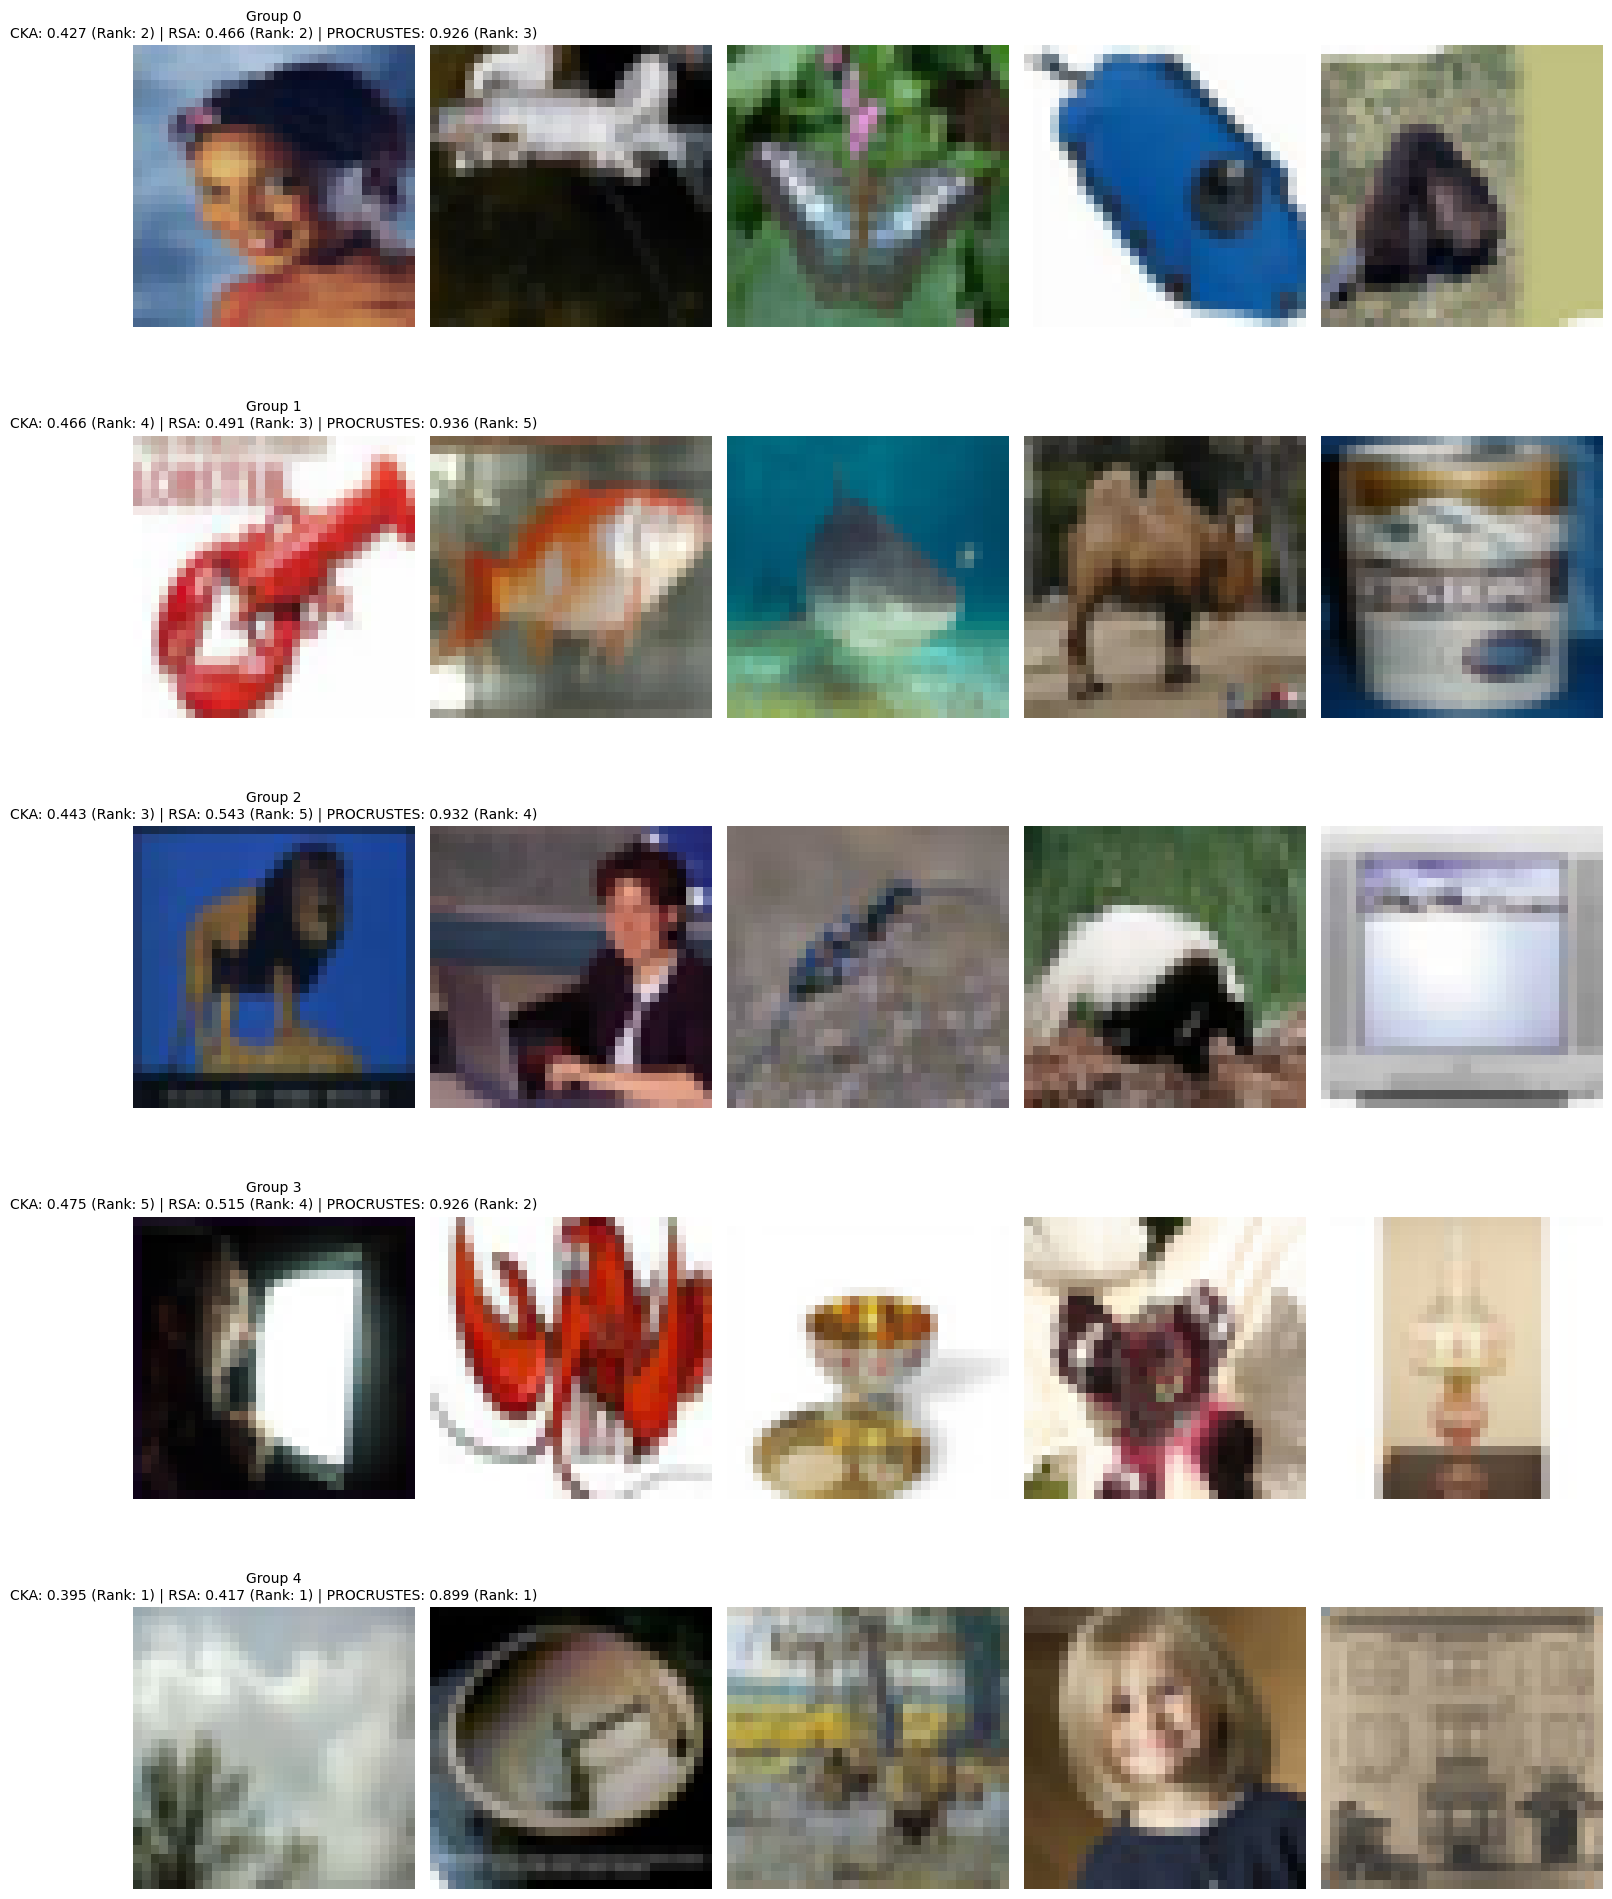

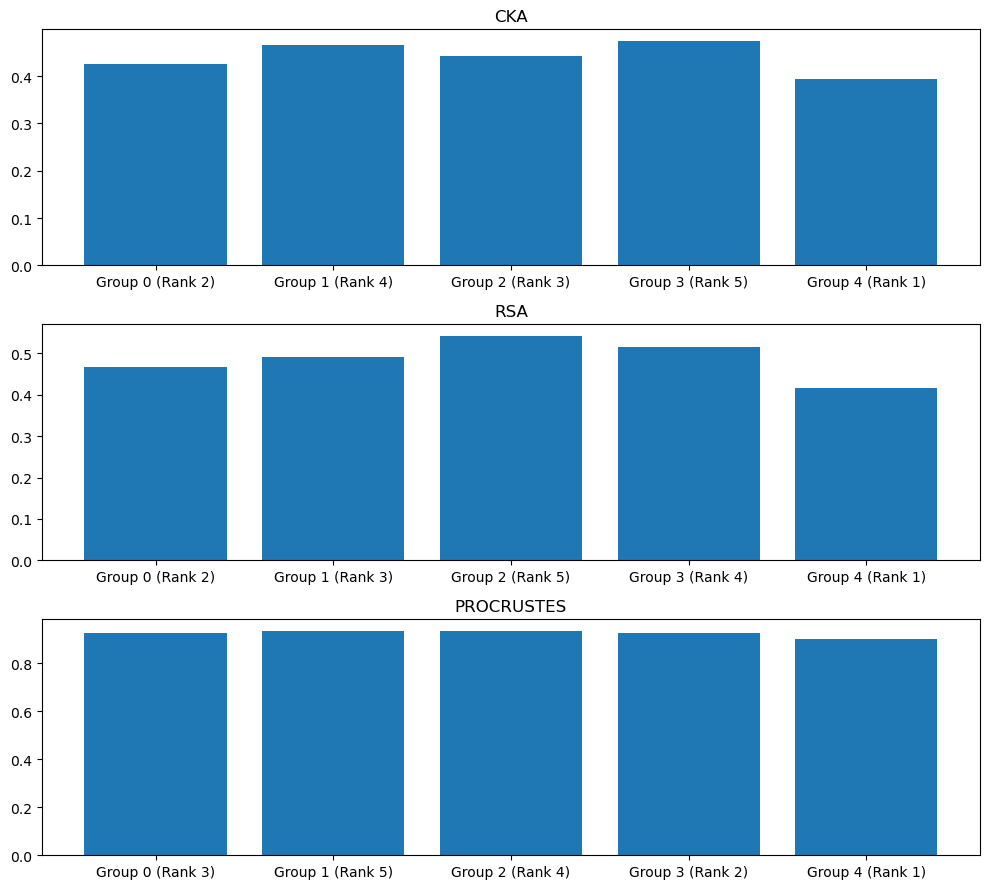

In [8]:
# this shows the results of the comparison
# and a subset of  images in each group
visualize_results(groups, results, rankings, fnames, output_dir)

In [9]:
# from the rankings, we find the group that maximizes the difference between the models
# first we score the groups based on the rankings
# for each metric a group gets a score of 5 if it is the best, 4 if it is the second best and so on
group_scores = {i: 0 for i in range(5)}
for method in rankings.keys():
    for group_id, rank_info in rankings[method].items():
        score = 5 - rank_info['rank']
        group_scores[group_id] += score
        
# the group with the highest score is the one that maximizes the difference between the models
best_group = max(group_scores, key=group_scores.get)
best_group


4

In [16]:
fnames = [ i.split('../data/cifar100_images/')[1] for i in fnames]

In [24]:
groups[best_group]

array([3598, 5313,  916, 3752,  525, 5168, 6572, 4386, 1084, 3456, 9292,
       5155, 3483, 8179, 6482, 7517, 2340, 4339, 2287, 4040])

In [26]:
fnames[3598]

'test/girl/image_987.png'

In [32]:
json_submission = {"differentiating_images": []}
dataset_name = dataset_name
submission_dir = '../red_team_submission'
if not os.path.exists(submission_dir):
    os.makedirs(submission_dir)

for i in groups[best_group]:
    json_submission['differentiating_images'].append({'dataset_name': dataset_name, 'image_identifier': fnames[i]})

print(json_submission)
json_submission = json.dumps(json_submission, indent=4)
with open(f'{submission_dir}/red_team_submission.json', 'w') as f:
    f.write(json_submission)


{'differentiating_images': [{'dataset_name': 'cifar100', 'image_identifier': 'test/girl/image_987.png'}, {'dataset_name': 'cifar100', 'image_identifier': 'test/orange/image_19.png'}, {'dataset_name': 'cifar100', 'image_identifier': 'test/bottle/image_2428.png'}, {'dataset_name': 'cifar100', 'image_identifier': 'test/house/image_528.png'}, {'dataset_name': 'cifar100', 'image_identifier': 'test/bed/image_2607.png'}, {'dataset_name': 'cifar100', 'image_identifier': 'test/mushroom/image_7060.png'}, {'dataset_name': 'cifar100', 'image_identifier': 'test/rabbit/image_7230.png'}, {'dataset_name': 'cifar100', 'image_identifier': 'test/lion/image_8545.png'}, {'dataset_name': 'cifar100', 'image_identifier': 'test/bowl/image_8335.png'}, {'dataset_name': 'cifar100', 'image_identifier': 'test/fox/image_5945.png'}, {'dataset_name': 'cifar100', 'image_identifier': 'test/tulip/image_9228.png'}, {'dataset_name': 'cifar100', 'image_identifier': 'test/mushroom/image_5838.png'}, {'dataset_name': 'cifar100